# Data Supremacy Challenge
This solution is part of "The Data Supremacy" challenge organized by Analytics Vidhya. The challenge involves building a model which can predict the probability that an enrollee is looking for a job given his/her current credentials/demographics/experience

In [352]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import model_selection

## 1. Loading and first look on the data

In [353]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,enrolled_university.1,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [354]:
train_df.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'enrolled_university.1',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [355]:
train_df.info()
print('_'*120)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18359 entries, 0 to 18358
Data columns (total 14 columns):
enrollee_id               18359 non-null int64
city                      18359 non-null object
city_development_index    18359 non-null float64
gender                    14261 non-null object
relevent_experience       18359 non-null object
enrolled_university       18017 non-null object
enrolled_university.1     17902 non-null object
major_discipline          15521 non-null object
experience                18300 non-null object
company_size              13580 non-null object
company_type              13320 non-null object
last_new_job              17992 non-null object
training_hours            18359 non-null int64
target                    18359 non-null int64
dtypes: float64(1), int64(3), object(10)
memory usage: 2.1+ MB
________________________________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>

**Seems like following features have missing values:**
-  gender
-  enrolled_university
-  enrolled_university.1 
-  major_discipline 
-  experience
-  company_size 
-  company_type 
-  last_new_job

Also the enrollee_id feature is not relevant with target value so I may drop it later

In [356]:
train_df.describe()

,enrollee_id,city_development_index,training_hours,target
count,18359.000000,18359.000000,18359.000000,18359.000000
mean,16729.360096,0.847140,65.899014,0.132088
std,9643.749725,0.110189,60.885300,0.338595
min,1.000000,0.448000,1.000000,0.000000
25%,8378.500000,0.796000,23.000000,0.000000
50%,16706.000000,0.910000,47.000000,0.000000
75%,25148.500000,0.920000,89.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [357]:
train_df.describe(include=['O']) #to describe categorical data

,city,gender,relevent_experience,enrolled_university,enrolled_university.1,major_discipline,experience,company_size,company_type,last_new_job
count,18359,14261,18359,18017,17902,15521,18300,13580,13320,17992
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4358,12884,13596,13659,10769,13738,3437,3120,10051,7567


# 2. Analysis by pivoting features

## i. Numerical Features

###  city_development_index

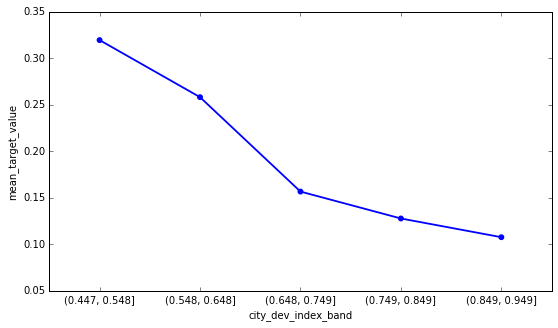

  city_dev_index_band  mean_target_value
0      (0.447, 0.548]           0.319672
1      (0.548, 0.648]           0.258317
2      (0.648, 0.749]           0.156797
3      (0.749, 0.849]           0.127861
4      (0.849, 0.949]           0.107742


In [358]:
plt.figure(figsize=(9,5))

#as city_dev_index is continuous-numerical type we can split it into different bands and then analyze its trend with the target 
#values.
#First I made a new dataframe for this analysis
city_dev_cut = pd.cut(train_df['city_development_index'], 5)
city_dev_cut1 = pd.DataFrame({'city_dev_index_band':city_dev_cut,'mean_target_value':train_df['target']})
city_dev = city_dev_cut1.groupby('city_dev_index_band', as_index=False).mean().\
sort_values(by='mean_target_value',ascending=False)

#then I just plotted it using seaborn
sns.pointplot(x = city_dev['city_dev_index_band'].values, y=city_dev['mean_target_value'].values)
plt.xlabel('city_dev_index_band')
plt.ylabel('mean_target_value')
plt.show()
print(city_dev)

**Conclusion**= The city_dev_index negatively correlated with the target value and it shows a really strong trend with it

### training hours

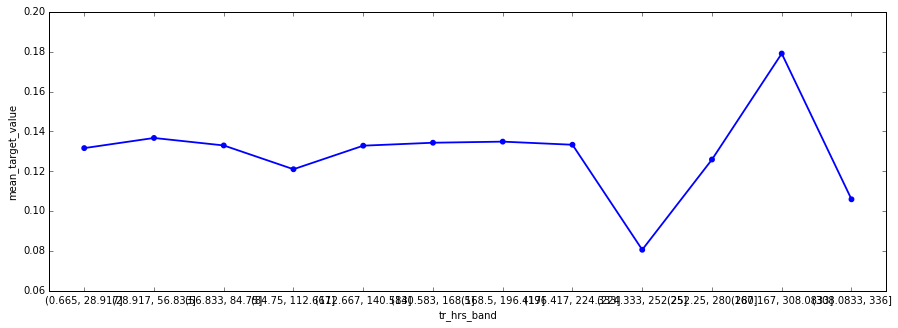

            tr_hrs_band  mean_target_value
10  (280.167, 308.0833]           0.179104
1      (28.917, 56.833]           0.136740
6      (168.5, 196.417]           0.134897
5      (140.583, 168.5]           0.134346
7    (196.417, 224.333]           0.133333
2       (56.833, 84.75]           0.132987
4    (112.667, 140.583]           0.132867
0       (0.665, 28.917]           0.131647
9     (252.25, 280.167]           0.125926
3      (84.75, 112.667]           0.121045
11      (308.0833, 336]           0.105960
8     (224.333, 252.25]           0.080645


In [359]:
#for training hours the analysis is same as above
plt.figure(figsize=(15,5))

tr_hrs_cut = pd.cut(train_df['training_hours'], 12)
tr_hrs_cut1 = pd.DataFrame({'tr_hrs_band':tr_hrs_cut,'mean_target_value':train_df['target']})
tr_hrs = tr_hrs_cut1.groupby('tr_hrs_band', as_index=False).mean().\
sort_values(by='mean_target_value',ascending=False)

sns.pointplot(x = tr_hrs['tr_hrs_band'].values, y=tr_hrs['mean_target_value'].values)
plt.xlabel('tr_hrs_band')
plt.ylabel('mean_target_value')
plt.show()
print(tr_hrs)

**Conclusion**= The training_hours shows a rather weird trend with the target value specifically for enrollees with high number of training hours seems to have equal chance of looking for a job. In any case there **no clear correlation of this feature with target value**

## ii. Categorical Features 

### gender

In [360]:
print(train_df[['gender', 'target']].groupby(['gender'], as_index=False).count().sort_values(by='target', ascending=False))
print('_'*30)
print(train_df[['gender', 'target']].groupby(['gender'], as_index=False).mean().sort_values(by='target', ascending=False))

   gender  target
1    Male   12884
0  Female    1188
2   Other     189
______________________________
   gender    target
2   Other  0.153439
0  Female  0.150673
1    Male  0.122477


**Conclusion**= The missing values in gender seems mostly of the type 'Female' as they have comparable mean target value with the Female enrollees 

###  relevent_experience	

In [361]:
print(train_df[['relevent_experience', 'target']].groupby(['relevent_experience'], as_index=False).count()\
      .sort_values(by='target', ascending=False))
print('_'*50)
print(train_df[['relevent_experience', 'target']].groupby(['relevent_experience'], as_index=False).mean()\
      .sort_values(by='target', ascending=False))

       relevent_experience  target
0  Has relevent experience   13596
1   No relevent experience    4763
__________________________________________________
       relevent_experience   target
1   No relevent experience  0.17447
0  Has relevent experience  0.11724


**Conclusion** = Those with no relevent exp seems to be more interested in the job :P. Later I will convert these feature values into numeric categorical variable

### enrolled_university

In [362]:
print(train_df[['enrolled_university', 'target']].groupby(['enrolled_university'], as_index=False).count()\
      .sort_values(by='target', ascending=False))
print('_'*50)
print(train_df[['enrolled_university', 'target']].groupby(['enrolled_university'], as_index=False).mean()\
      .sort_values(by='target', ascending=False))

  enrolled_university  target
2       no_enrollment   13659
0    Full time course    3187
1    Part time course    1171
__________________________________________________
  enrolled_university    target
0    Full time course  0.190461
1    Part time course  0.148591
2       no_enrollment  0.116260


**Conclusion** = More the education more the need for a job. A positive correlation can be seen from this trend. Later I will convert these feature values into numeric categorical variable

### enrolled_university.1 (type)

In [363]:
print(train_df[['enrolled_university.1', 'target']].groupby(['enrolled_university.1'], as_index=False).count()\
      .sort_values(by='target', ascending=False))
print('_'*50)
print(train_df[['enrolled_university.1', 'target']].groupby(['enrolled_university.1'], as_index=False).mean()\
      .sort_values(by='target', ascending=False))

  enrolled_university.1  target
0              Graduate   10769
2               Masters    4319
1           High School    2032
3                   Phd     459
4        Primary School     323
__________________________________________________
  enrolled_university.1    target
0              Graduate  0.142260
2               Masters  0.118777
1           High School  0.118602
3                   Phd  0.115468
4        Primary School  0.077399


**Conclusion** = Seems like education really plays a role in job demand by enrollee. A positive correlation can be seen from this trend. Later I will convert these feature values into numeric categorical variable

### major_discipline	 

In [364]:
print(train_df[['major_discipline', 'target']].groupby(['major_discipline'], as_index=False).count()\
      .sort_values(by='target', ascending=False))   #train_df.major_discipline.value_counts() this can also be used
print('_'*50)
print(train_df[['major_discipline', 'target']].groupby(['major_discipline'], as_index=False).mean()\
      .sort_values(by='target', ascending=False))

  major_discipline  target
5             STEM   13738
2       Humanities     688
4            Other     343
1  Business Degree     307
0             Arts     239
3         No Major     206
__________________________________________________
  major_discipline    target
5             STEM  0.136628
2       Humanities  0.135174
1  Business Degree  0.127036
4            Other  0.107872
0             Arts  0.104603
3         No Major  0.097087


**Conclusion** = Relevent major_discipline people shows more interest as expected but overall there is very less correlation

### experience 

In [365]:
print(train_df[['experience', 'target']].groupby(['experience'], as_index=False).count()\
      .sort_values(by='target', ascending=False))
print('_'*50)
a = train_df[['experience', 'target']].groupby(['experience'], as_index=False).mean()\
      .sort_values(by='target', ascending=False)
print(a)
exp_list = a['experience'].tolist()

   experience  target
21        >20    3437
15          5    1309
14          4    1250
13          3    1159
16          6    1125
11          2     992
19          9     979
1          10     967
17          7     950
18          8     755
6          15     695
2          11     667
5          14     602
7          16     549
3          12     497
0           1     452
20         <1     416
4          13     412
8          17     347
10         19     308
9          18     286
12         20     146
__________________________________________________
   experience    target
20         <1  0.242788
0           1  0.238938
11          2  0.172379
14          4  0.168800
13          3  0.164797
17          7  0.146316
15          5  0.140565
16          6  0.136000
5          14  0.124585
2          11  0.124438
1          10  0.124095
19          9  0.120531
4          13  0.116505
18          8  0.113907
6          15  0.110791
12         20  0.109589
10         19  0.107143
3          

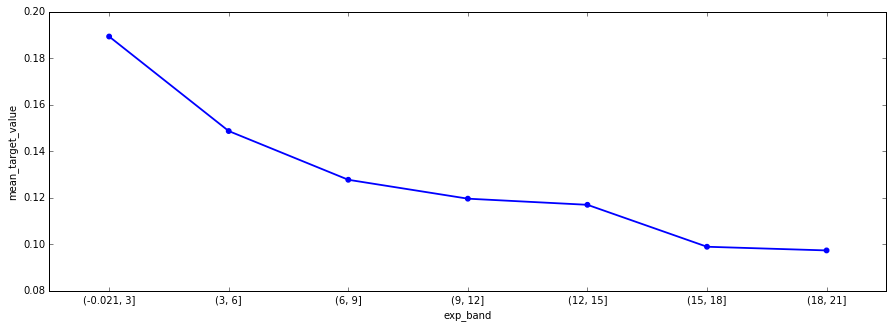

      exp_band  mean_target_value
0  (-0.021, 3]           0.189409
1       (3, 6]           0.148751
2       (6, 9]           0.127794
3      (9, 12]           0.119662
4     (12, 15]           0.117028
5     (15, 18]           0.098985
6     (18, 21]           0.097404


In [366]:
train_df1 = train_df.copy() 
dict_ = {}
for i in range(21):
    dict_[str(i)] = int(i)
dict_['>20'] = 21
dict_['<1'] = 0
dict_['Other'] = 1
train_df1['experience'] = train_df1['experience'].map(dict_).fillna(0).astype(int)

plt.figure(figsize=(15,5))

exp_cut = pd.cut(train_df1['experience'], 7)
exp_cut1 = pd.DataFrame({'exp_band':exp_cut,'mean_target_value':train_df1['target']})
exp = exp_cut1.groupby('exp_band', as_index=False).mean().\
sort_values(by='mean_target_value',ascending=False)

sns.pointplot(x = exp['exp_band'].values, y=exp['mean_target_value'].values)
plt.xlabel('exp_band')
plt.ylabel('mean_target_value')
plt.show()
print(exp)

**Conclusion**= The <1 will become 0 and for Other category of experience from its nature it seems to around 1-2 years later we will create experience bands so lets make 'Other' = 1.5. Also the negative correlation can be seen here.

### company_size	 

In [367]:
print(train_df[['company_size', 'target']].groupby(['company_size'], as_index=False).count()\
      .sort_values(by='target', ascending=False))
print('_'*50)
print(train_df[['company_size', 'target']].groupby(['company_size'], as_index=False).mean()\
      .sort_values(by='target', ascending=False))

  company_size  target
4        50-99    3120
1      100-500    2698
3       10000+    2044
0        10/49    1466
2    1000-4999    1399
7          <10    1360
5      500-999     902
6    5000-9999     591
__________________________________________________
  company_size    target
0        10/49  0.134379
6    5000-9999  0.125212
3       10000+  0.120841
5      500-999  0.116408
2    1000-4999  0.109364
7          <10  0.107353
1      100-500  0.103781
4        50-99  0.100321


**Conclusion** = Here all the categories shows more or less similar score for mean target value. This indicates very less correlation

### company_type

In [368]:
print(train_df[['company_type', 'target']].groupby(['company_type'], as_index=False).count()\
      .sort_values(by='target', ascending=False))
print('_'*50)
print(train_df[['company_type', 'target']].groupby(['company_type'], as_index=False).mean()\
      .sort_values(by='target', ascending=False))

          company_type  target
5              Pvt Ltd   10051
1       Funded Startup    1038
4        Public Sector     996
0  Early Stage Startup     582
2                  NGO     534
3                Other     119
__________________________________________________
          company_type    target
3                Other  0.159664
4        Public Sector  0.152610
2                  NGO  0.129213
0  Early Stage Startup  0.127148
5              Pvt Ltd  0.109143
1       Funded Startup  0.092486


**Conclusion**= Here there is a slightly positive correlation between 'company_type' and target

###  last_new_job

In [369]:
print(train_df[['last_new_job', 'target']].groupby(['last_new_job'], as_index=False).count()\
      .sort_values(by='target', ascending=False))
print('_'*50)
print(train_df[['last_new_job', 'target']].groupby(['last_new_job'], as_index=False).mean()\
      .sort_values(by='target', ascending=False))

  last_new_job  target
0            1    7567
4           >4    3339
1            2    2835
5        never    2186
3            4    1038
2            3    1027
__________________________________________________
  last_new_job    target
5        never  0.141812
3            4  0.141618
1            2  0.137213
0            1  0.134532
2            3  0.126582
4           >4  0.108116


**Conclusion**= There is almost no correlation here

### city

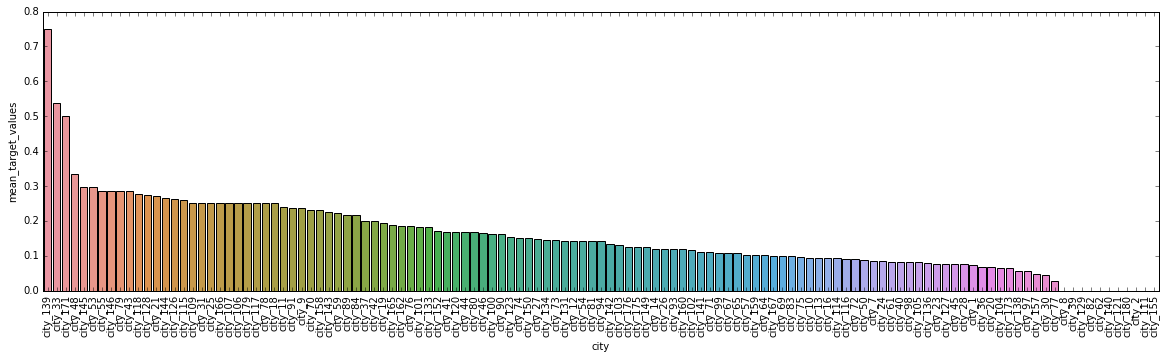

         city  mean_target_values
32   city_139            0.750000
73    city_33            0.538462
54   city_171            0.500000
84    city_48            0.333333
39   city_145            0.297297
86    city_53            0.296296
88    city_55            0.285714
40   city_146            0.285714
107   city_79            0.285714
80    city_43            0.285714


In [370]:
plt.figure(figsize=(20,5))

city_df = pd.DataFrame({'city':train_df['city'],'mean_target_values':train_df['target']})
city = city_df.groupby('city', as_index=False).mean().\
sort_values(by='mean_target_values',ascending=False)

sns.barplot(x = city['city'].values, y=city['mean_target_values'].values)
plt.xticks(rotation='vertical')
plt.xlabel('city')
plt.ylabel('mean_target_values')
plt.show()
print(city.head(10))
city_list = city['city'].tolist()

**Conclusion**= City feature certainly shows a highly positive correlation but I need to label these values later

## 3. Data Wrangling

Let's list our tasks for this part of our model:

*Note: Every action in this part must be taken in both training as well test data*

-  removing Enrollee ID 
-  replacing missing values in gender by 'Female'/'Other' for our first approach
-  replacing missing values in 'enrolled_university', 'enrolled_university.1', 'major_discipline', 'experience', 'company_size', company_type', 'last_new_job' these features

-  labeling all the values of city,  relevent_experience,  enrolled_university,  enrolled_university.1, major_discipline,  company_type, company_size, last_new_job features
-  labeling by first converting into ordinal values of the experience feature
-  grouping and then labeling numerical features training_hours and city_dev_index


In [371]:
train_df = train_df.drop('enrollee_id', axis=1)

In [372]:
train_df.fillna('Other', inplace=True)
train_df['gender'] = train_df['gender'].map({'Male':0, 'Female':1, 'Other':1}).astype(int)
test_df.fillna('Other', inplace=True)
test_df['gender'] = test_df['gender'].map({'Male':0, 'Female':1, 'Other':1}).astype(int)

In [373]:
print(train_df.gender.unique())
print(test_df.gender.unique())

[0 1]
[1 0]


In [374]:
dict_ = {}
for index, value in enumerate(exp_list):
    dict_[str(value)] = int(index)
dict_['Other'] = 1
train_df['experience'] = train_df['experience'].map(dict_)
test_df['experience'] = test_df['experience'].map(dict_)

In [375]:
combine = [train_df, test_df] #should have done this before :P
le = LabelEncoder()

In [376]:
for dataset in combine:
    dataset['experience'] = pd.cut(dataset['experience'], 5)
    dataset['experience'] = le.fit_transform(dataset['experience'])

In [377]:
dict_ = {}
for index, value in enumerate(city_list):
    dict_[str(value)] = int(index)
train_df['city'] = train_df['city'].map(dict_)
test_df['city'] = test_df['city'].map(dict_)

In [378]:
for dataset in combine:
    dataset['city'] = pd.cut(dataset['city'], 6)
    dataset['city'] = le.fit_transform(dataset['city'])

In [379]:
# dict_ = {}
# for i in range(21):
#     dict_[str(i)] = int(i)
# dict_['>20'] = 21
# dict_['<1'] = 0
# dict_['Other'] = 1.5
# train_df['experience'] = train_df['experience'].map(dict_)
# test_df['experience'] = test_df['experience'].map(dict_)

In [380]:
# print(train_df.experience.unique())
# print(test_df.experience.unique())

In [381]:
# train_df['exp_band'] = pd.cut(train_df['experience'], 5)

In [382]:
# train_df.exp_band.unique()

In [383]:
# train_df.loc[ train_df['experience'] <= 4, 'experience'] = 0
# train_df.loc[(train_df['experience'] > 4) & (train_df['experience'] <= 8), 'experience'] = 1
# train_df.loc[(train_df['experience'] > 8) & (train_df['experience'] <= 12), 'experience'] = 2
# train_df.loc[(train_df['experience'] > 12) & (train_df['experience'] <= 16), 'experience'] = 3
# train_df.loc[(train_df['experience'] > 16) & (train_df['experience'] <= 21), 'experience'] = 4
# train_df.drop('exp_band',axis=1, inplace=True)

In [384]:
# test_df.loc[ test_df['experience'] <= 4, 'experience'] = 0
# test_df.loc[(test_df['experience'] > 4) & (test_df['experience'] <= 8), 'experience'] = 1
# test_df.loc[(test_df['experience'] > 8) & (test_df['experience'] <= 12), 'experience'] = 2
# test_df.loc[(test_df['experience'] > 12) & (test_df['experience'] <= 16), 'experience'] = 3
# test_df.loc[(test_df['experience'] > 16) & (test_df['experience'] <= 21), 'experience'] = 4

In [385]:
train_df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,enrolled_university.1,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,4,0.689,0,Has relevent experience,no_enrollment,Graduate,STEM,0,100-500,Pvt Ltd,1,106,0
1,5,0.923,0,Has relevent experience,no_enrollment,Graduate,STEM,3,<10,Funded Startup,1,69,0
2,5,0.910,1,Has relevent experience,no_enrollment,Graduate,STEM,3,50-99,Public Sector,2,4,0
3,4,0.666,0,Has relevent experience,no_enrollment,Graduate,STEM,3,50-99,Pvt Ltd,1,26,0
4,3,0.887,1,No relevent experience,no_enrollment,Masters,STEM,1,Other,Other,2,88,1


In [386]:
train_df.company_type.unique()

array(['Pvt Ltd', 'Funded Startup', 'Public Sector', 'Other',
       'Early Stage Startup', 'NGO'], dtype=object)

In [387]:
train_df.columns.values

array(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'enrolled_university.1', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'], dtype=object)

In [388]:
# for dataset in combine:
#     dataset['company_type'] = dataset['company_type'].map({'Pvt Ltd':0, 'Funded Startup':1, 'Public Sector':2, 'Other':3,
#        'Early Stage Startup':4, 'NGO':5}).astype(int)

#above method of mapping can also be used but it is tidious
f_list = ['relevent_experience','enrolled_university', 'enrolled_university.1', 'major_discipline',\
          'company_size', 'company_type', 'last_new_job']
for dataset in combine:
    for feature in f_list:
        dataset[str(feature)] = le.fit_transform(dataset[str(feature)]) 

for feature in f_list: 
    print('Labels of {} = {}'.format(feature, train_df[feature].unique()) )

Labels of relevent_experience = [0 1]
Labels of enrolled_university = [3 0 2 1]
Labels of enrolled_university.1 = [0 2 1 4 3 5]
Labels of major_discipline = [5 4 3 1 0 2]
Labels of company_size = [1 7 4 8 6 3 2 5 0]
Labels of company_type = [5 1 4 3 0 2]
Labels of last_new_job = [0 1 2 4 6 3 5]


In [389]:
for dataset in combine:
    dataset['city_development_index'] = pd.cut(dataset['city_development_index'], 5)
    dataset['city_development_index'] = le.fit_transform(dataset['city_development_index'])

In [390]:
print('Labels of city_dev_index = {}'.format(train_df['city_development_index'].unique()) )

Labels of city_dev_index = [2 4 1 3 0]


In [391]:
for dataset in combine:
    dataset['training_hours'] = pd.cut(dataset['training_hours'], 12)
    dataset['training_hours'] = le.fit_transform(dataset['training_hours'])

In [392]:
print('Labels of tr_hrs = {}'.format(train_df['training_hours'].unique()) )

Labels of tr_hrs = [11 10  0  7  8  1  6  2  3  4  9  5]


## Machine Learning Model 
This is the final step where now I will train a model according to our dataset which is of 'Supervised-Classification' type. Also some additional things which should be considered are as follows:
-  The features like training_hours, major_discipline, company_size have almost no correlation with our target so we can do an analysis with dropping these features
-  'experience' needs to be labelled manually by grouping them according to higher mean value of target (which is just random now)
-  'city' need to be labelled properly by grouping higher mean target value variables together in some small no of groups around 7-8

In [393]:
test_size = 0.25
seed = 7
score='accuracy'

In [394]:
X_all = train_df.drop("target", axis=1)
y_all = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = test_size, random_state= seed)
X_train.shape, y_train.shape, X_test.shape

((13769, 12), (13769,), (4590, 12))

In [395]:
#A function for training various classification models on our data
def models_C(X_train, y_train, score):
    models = []
    result = []
    
    models.append(('RFC', RandomForestClassifier(n_estimators = 300)))
    models.append(('GBC', GradientBoostingClassifier(n_estimators = 300)))
    models.append(('SVM', SVC()))
    models.append(('SGD', SGDClassifier()))
    models.append(('LR', LogisticRegression()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('KNC', KNeighborsClassifier()))
    models.append(('GNB', GaussianNB()))
    models.append(('Per', Perceptron()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
        
    for name, model in models:
        kfold = model_selection.KFold(n_splits = 10, random_state=seed)
        cv_score = cross_val_score(model, X_train, y_train, cv=kfold, scoring=score)
        
        result.append((name, cv_score.mean(), cv_score.std()))
    return result


In [408]:
models_C(X_train, y_train, score)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.5/dist-packages/s

[('RFC', 0.85162395923054834, 0.0073493963210415113),
 ('GBC', 0.86658502009761695, 0.0094991698410503752),
 ('SVM', 0.86832820337437311, 0.0096628313749872498),
 ('SGD', 0.73041965386499119, 0.25239735229865667),
 ('LR', 0.8684008250156221, 0.0093958643286981454),
 ('DT', 0.7764545966965597, 0.010315161375893521),
 ('KNC', 0.85300382319163659, 0.010419967778183291),
 ('GNB', 0.81727091461046086, 0.0086257194609071081),
 ('Per', 0.7164763515225212, 0.21737639127309927),
 ('LDA', 0.86854606829812031, 0.0093068930460308858)]

RFC, GBC, SVM, LR, LDA

In [397]:
# svc = SVC()
# rfc = RandomForestClassifier(n_estimators=300, n_jobs=-1)
# lr = LinearRegression()
# lda = LinearDiscriminantAnalysis()
# gbc = GradientBoostingClassifier(n_estimators=300)

# names = ['SVM', 'Random Forest', 'LDA', 'Gradient Boosting']
# clfs = [svc, rfc, lda, gbc]

# for name, clf in zip(names,clfs):
#     clf.fit(X_train,y_train)
#     pred = clf.predict(X_test)
#     print(name)
#     print(accuracy_score(y_test, pred))
#     print(confusion_matrix(y_test, pred))
#     print(classification_report(y_test, pred))

In [398]:
# X_d = X_all.drop(['training_hours', 'major_discipline'], axis=1)
# y_d = y_all
# X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_all, y_all, test_size = test_size, random_state= seed)

In [409]:
models_C(X_train_d, y_train_d, score)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.5/dist-packages/s

[('RFC', 0.85089763726334644, 0.006906336773017269),
 ('GBC', 0.86651239845636785, 0.0096410049678186862),
 ('SVM', 0.86832820337437311, 0.0096628313749872498),
 ('SGD', 0.83739122587019299, 0.042889475636060811),
 ('LR', 0.8684008250156221, 0.0093958643286981454),
 ('DT', 0.77790713507625264, 0.0099508691043514296),
 ('KNC', 0.85300382319163659, 0.010419967778183291),
 ('GNB', 0.81727091461046086, 0.0086257194609071081),
 ('Per', 0.7164763515225212, 0.21737639127309927),
 ('LDA', 0.86854606829812031, 0.0093068930460308858)]

In [410]:
X_t = test_df.drop('enrollee_id', axis=1)
X_t_d = X_t.drop(['training_hours', 'major_discipline'], axis=1)
svc = SVC()
gba = GradientBoostingClassifier(n_estimators=1000)
rfc = RandomForestClassifier(n_estimators=2000, n_jobs=-1)
lda = LinearDiscriminantAnalysis()
rfc.fit(X_all, y_all)
y_pred = rfc.predict(X_t)

In [411]:
submission = pd.DataFrame({
        "enrollee_id": test_df["enrollee_id"],
        "target": y_pred
    })

In [412]:
submission.set_index('enrollee_id', inplace=True)
submission.head()

,target
enrollee_id,
16548,0
12036,0
11061,0
5032,0
17599,0


In [413]:
submission.to_csv('submission_rfc_final3.csv')